Took the first 3 blocks of code from Yerlan's LC Compression Collab


In [ ]:
#! git clone https://github.com/UCMerced-ML/LC-model-compression

Cloning into 'LC-model-compression'...
remote: Enumerating objects: 166, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 166 (delta 63), reused 142 (delta 42), pack-reused 0
Receiving objects: 100% (166/166), 3.19 MiB | 9.83 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [ ]:
# ! pip3 install -e ./LC-model-compression

Obtaining file:///content/LC-model-compression
  Running setup.py develop for lc


## IMPORTANT!
At this point you need to restart the runtime by doing "Runtime => Restart Runtime"

After doing the restart, I recommend just commenting out the 2 lines of code above so that we can press run all

## Training the Neural Network

### Import packages

In [ ]:
#%matplotlib inline

import lc
from lc.torch import ParameterTorch as Param, AsVector, AsIs
from lc.compression_types import ConstraintL0Pruning, LowRank, RankSelection, AdaptiveQuantization

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from timeit import default_timer as timer
from datetime import timedelta
from prettytable import PrettyTable

torch.manual_seed(0)
np.random.seed(0)
torch.set_num_threads(4)
batchsize = 2048
num_workers = 2
nnloss = torch.nn.CrossEntropyLoss()


In [ ]:
#https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
#https://stackabuse.com/python-check-if-string-contains-substring/
def count_parameters_no_bias(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        if name != None and 'bias' in name: continue 
        else:
          param = parameter.numel()
          table.add_row([name, param])
          total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

### Making the Neural Network

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')  
print(device)

cuda


In [ ]:
def load_reference_net():
    net2 = Net().to(device)
    state_dict = torch.load("best_parameter_project2_part2_model.pth", map_location=device)
    net2.load_state_dict(state_dict)
    net2.eval()
    return net2

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 20, 5)
        self.conv2 = nn.Conv2d(20, 50, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(50 * 4 * 4 , 500)  # 28*28 from image dimension 
        self.fc2 = nn.Linear(500, 5)

    def forward(self, x):
      # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)
print(net)
total_parameters = count_parameters(net)
total_parameters_no_bias = count_parameters_no_bias(net)
print(total_parameters)
print(total_parameters_no_bias)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=5, bias=True)
)
+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    500     |
|  conv1.bias  |     20     |
| conv2.weight |   25000    |
|  conv2.bias  |     50     |
|  fc1.weight  |   400000   |
|   fc1.bias   |    500     |
|  fc2.weight  |    2500    |
|   fc2.bias   |     5      |
+--------------+------------+
Total Trainable Params: 428575
+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    500     |
| conv2.weight |   25000    |
|  fc1.weight  |   400000   |
|  fc2.weight  |    2500    |
+--------------+------------+
Total Trainable Params: 428000
428575
428000


In [ ]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

8
torch.Size([20, 1, 5, 5])


In [ ]:
# input = torch.randn(1, 1, 28, 28).to(device)
# out = net(input)
# print(out)

### Getting the subset MNIST dataset

In [ ]:
def data_loader(batch_size = batchsize, n_workers = num_workers):
    train_data_th = datasets.MNIST(root='./datasets', download=True, train=True)
    test_data_th = datasets.MNIST(root='./datasets', download=True, train=False)

    label = [1, 2, 3 ,4, 6]
    data_train_fea = np.array(train_data_th.data[:]).astype(np.float32)
    data_train_fea = (data_train_fea / 255)
    data_train_gnd = np.array(train_data_th.targets)
    ctr1_idx = np.where(data_train_gnd[:] == label[0])
    ctr2_idx = np.where(data_train_gnd[:] == label[1])
    ctr3_idx = np.where(data_train_gnd[:] == label[2])
    ctr4_idx = np.where(data_train_gnd[:] == label[3])
    ctr6_idx = np.where(data_train_gnd[:] == label[4])
    ctr1_idx = np.array(ctr1_idx)
    ctr2_idx = np.array(ctr2_idx)
    ctr3_idx = np.array(ctr3_idx)
    ctr4_idx = np.array(ctr4_idx)
    ctr6_idx = np.array(ctr6_idx)
    total_train_valid_idx = np.concatenate((ctr1_idx, ctr2_idx, ctr3_idx, ctr4_idx, ctr6_idx),axis = None)
    np.random.shuffle(total_train_valid_idx)#forgot to add this line of code
    train_idx = total_train_valid_idx[:27000]
    valid_idx = total_train_valid_idx[27000:]

    data_total_train = data_train_fea[total_train_valid_idx]
    target_total_train = data_train_gnd[total_train_valid_idx]

    data_train = data_train_fea[train_idx]
    target_train = data_train_gnd[train_idx]

    data_validation = data_train_fea[valid_idx]
    target_validation = data_train_gnd[valid_idx]

    data_test_fea = np.array(test_data_th.data[:]).astype(np.float32)
    data_test_fea = (data_test_fea / 255)
    data_test_gnd = np.array(test_data_th.targets)
    cte1_idx = np.where(data_test_gnd[:] == label[0])
    cte2_idx = np.where(data_test_gnd[:] == label[1])
    cte3_idx = np.where(data_test_gnd[:] == label[2])
    cte4_idx = np.where(data_test_gnd[:] == label[3])
    cte6_idx = np.where(data_test_gnd[:] == label[4])
    cte1_idx = np.array(cte1_idx)
    cte2_idx = np.array(cte2_idx)
    cte3_idx = np.array(cte3_idx)
    cte4_idx = np.array(cte4_idx)
    cte6_idx = np.array(cte6_idx)
    test_idx = np.concatenate((cte1_idx, cte2_idx, cte3_idx, cte4_idx, cte6_idx),axis = None)

    data_test = data_test_fea[test_idx]
    target_test = data_test_gnd[test_idx]

    ##not sure what this is doing but it was here in both the neural network tutorial and in yerlan's collab
    dtrain_mean = data_train.mean(axis=0)
    data_train -= dtrain_mean
    data_validation -=dtrain_mean
    data_total_train -= dtrain_mean
    data_test -= dtrain_mean
    ##

    #######
    #https://discuss.pytorch.org/t/indexerror-target-2-is-out-of-bounds/69614/24
    tensor_target_train = torch.from_numpy(target_train)

    #print(tensor_target_train.size())
    # print(min(tensor_target_train))
    # print(max(tensor_target_train))
    unique_targets_train = torch.unique(tensor_target_train) #1,2,3,4,6
    # print('unique_targets_train: {}'.format(unique_targets_train))

    new_tensor_target_train = torch.empty_like(tensor_target_train) #size of tensor_target_train
    for idx, t in enumerate(unique_targets_train):
        # print('replacing {} with {}'.format(t, idx))
        new_tensor_target_train[tensor_target_train == t] = idx # [1,1,3,3]
    # print(new_tensor_target_train.size())
    # print(min(new_tensor_target_train))
    # print(max(new_tensor_target_train))

    tensor_target_validation = torch.from_numpy(target_validation)
    #print(tensor_target_validation.size())
    unique_targets_validation = torch.unique(tensor_target_validation)
    new_tensor_target_validation = torch.empty_like(tensor_target_validation)
    for idx, t in enumerate(unique_targets_validation):
      new_tensor_target_validation[tensor_target_validation == t] = idx

    tensor_target_test = torch.from_numpy(target_test)
    unique_targets_test = torch.unique(tensor_target_test)
    new_tensor_target_test = torch.empty_like(tensor_target_test)
    for idx, t in enumerate(unique_targets_test):
      new_tensor_target_test[tensor_target_test == t] = idx
    

    tensor_target_total_train = torch.from_numpy(target_total_train)
    unique_targets_total_train = torch.unique(tensor_target_total_train)
    new_tensor_target_total_train = torch.empty_like(tensor_target_total_train)
    for idx, t in enumerate(unique_targets_total_train):
      new_tensor_target_total_train[tensor_target_total_train == t] = idx


    train_data = TensorDataset(torch.from_numpy(data_train), new_tensor_target_train)
    validation_data = TensorDataset(torch.from_numpy(data_validation), new_tensor_target_validation)
    test_data = TensorDataset(torch.from_numpy(data_test), new_tensor_target_test)
    total_train_data = TensorDataset(torch.from_numpy(data_total_train), new_tensor_target_total_train)

    train_loader = DataLoader(train_data, num_workers=n_workers, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_data, num_workers = n_workers, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_data, num_workers=n_workers, batch_size=batch_size, shuffle=False)
    total_train_loader = DataLoader(total_train_data, num_workers = n_workers, batch_size = batch_size, shuffle = True)

    #return train_loader, validation_loader, test_loader, total_train_loader #-> use this one if still training model
    return total_train_loader, test_loader # use this one if already found optimized model

### Defining all the lists used

In [ ]:
plotepoch = []
plottrainloss = []
plotvalidloss = []
avg_train_loss = []
avg_valid_loss = []
plottrainacc = []
plotvalidacc = []
timetaken = []
loss_list = []
avg_train_err = []
avg_test_err = []

In [ ]:
def clearList():
    plotepoch.clear()
    plottrainloss.clear()
    plotvalidloss.clear()
    avg_train_loss.clear()
    avg_valid_loss.clear()
    plottrainacc.clear()
    plotvalidacc.clear()

### Calculating accuracy

In [ ]:
def calc_acc(loader, net):
    correct_cnt = 0
    total_cnt = 0
    net.eval()
    with torch.no_grad():
        for batch_inputs, batch_labels in loader:
            batch_inputs = batch_inputs.to(device=device)
            batch_labels = batch_labels.to(dtype=torch.long, device=device)
            out = net(batch_inputs[:,None, :,:])
            _, pred_labels = torch.max(out.data, 1)
            total_cnt += batch_labels.size(0)
            correct_cnt += (pred_labels == batch_labels).sum().item()
    

    accuracy = correct_cnt / total_cnt
    return accuracy

def calc_acc_loss(loader, net):
    correct_cnt = 0
    total_cnt = 0
    loss_list.clear()
    net.eval()
    with torch.no_grad():
        for batch_inputs, batch_labels in loader:
            batch_inputs = batch_inputs.to(device=device)
            batch_labels = batch_labels.to(dtype=torch.long, device=device)
            out = net(batch_inputs[:,None, :,:])
            loss = nnloss(out,batch_labels)
            loss_list.append(loss.item())
            _, pred_labels = torch.max(out.data, 1)
            total_cnt += batch_labels.size(0)
            correct_cnt += (pred_labels == batch_labels).sum().item()
    
    calc_loss = np.mean(loss_list)
    accuracy = correct_cnt / total_cnt
    return accuracy, calc_loss      

In [ ]:
def findAccNoTest(net):
    train_loader, validation_loader, test_loader, total_train_loader = data_loader()
    print(f'Train Accuracy: {100 * calc_acc(train_loader,net):.2f}%')
    print(f'Validation Accuracy: {100 * calc_acc(validation_loader,net):.2f}%')

def findAccWithTest(net):
    train_loader, validation_loader, test_loader, total_train_loader = data_loader()
    print(f'Train Accuracy: {100 * calc_acc(train_loader,net):.2f}%')
    print(f'Validation Accuracy: {100 * calc_acc(validation_loader,net):.2f}%')
    print(f'Test Accuracy: {100 *calc_acc(test_loader,net):.2f}%')

def findAccTrainTest(net):
    train_loader, test_loader = data_loader()
    print(f'Train Accuracy: {100 * calc_acc(train_loader,net):.2f}%')
    print(f'Test Accuracy: {100 *calc_acc(test_loader,net):.2f}%')
    

In [ ]:
def train_test_acc_eval_f(net):
    train_loader, test_loader = data_loader()
    acc_train, loss_train = calc_acc_loss(train_loader,net)
    acc_test, loss_test = calc_acc_loss(test_loader,net)

    print(f"Train err: {100-acc_train*100:.2f}%, train loss: {loss_train}")
    print(f"TEST ERR: {100-acc_test*100:.2f}%, test loss: {loss_test}")
    avg_train_err.append(100-acc_train*100)
    avg_test_err.append(100-acc_test*100)
    

### Confusion Matrix

In [ ]:
#https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7

def confusion_matrix1(test_loader):
    y_pred = []
    y_true = []

    for x, target in test_loader:
        x = x.to(device=device)[:,None, :,:]
        target = target.to(device=device, dtype=torch.long)
        out = net(x)
        out = (torch.max(torch.exp(out),1)[1]).data.cpu().numpy()
        y_pred.extend(out)
        target = target.data.cpu().numpy()
        y_true.extend(target)

    labels = [1,2,3,4,6]
    cf_matrix = confusion_matrix(y_true,y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index = [i for i in labels], columns = [i for i in labels])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)

### Yerlan's Suggestions for Project 2 Part 1 Part 1

In [ ]:
#select reasonable settings
#every 10 epoch 0.9 schedular
#have 60k training
#10k test
#choose lr: 0.01 - 0.1
# lr decay: 0.95 every 10 epoch
# epoch 100-150
#sgd: use momentum
# for momentum: default 0.9 okay
# 5 - 10 experiments
#once found best parameters
#use them on entire dataset 60k
#split training 55k,5k train/valid
#in our case split training 27k,rest train/valid
#once found best parameters
#train model on all training
#report true test error on 10k only once
#use large as possible batch size that fits in gpu allocates like 2000 or 2048

### Training the Netural Network

In [ ]:
# uncomment to test parameters again
#if i set num_workers = 4 i get this warning
#/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary. cpuset_checked))
#So I will do what they suggest and switch to 2

def train_net(net):
    params = list(filter(lambda p: p.requires_grad, net.parameters()))
    optimizer = optim.SGD(params, lr=0.1, momentum=0.9, weight_decay = 0, nesterov=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    train_loader, validation_loader, test_loader, total_train_loader = data_loader()
    print("Before optimizing the model")
    findAccNoTest(train_loader, validation_loader, net)
    print("Training the Model")
    epochs = 100
    clearList()
    start = timer()
    for epoch in range(epochs):
        net.train()
        for x, target in train_loader:
            x = x.to(device=device)[:,None, :,:]
            target = target.to(device=device, dtype=torch.long)
            optimizer.zero_grad()
            out = net(x)
            loss = nnloss(out, target)
            loss.backward()
            avg_train_loss.append(loss.item())
            optimizer.step()
        scheduler.step()
        train_loss = np.mean(avg_train_loss)
        plotepoch.append(epoch)
        plottrainloss.append(train_loss)
        
        #https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/
        net.eval()
        with torch.no_grad():
            for x, target in validation_loader:
                x = x.to(device=device)[:,None, :,:]
                target = target.to(device=device, dtype=torch.long)
                out = net(x)
                loss = nnloss(out, target)
                avg_valid_loss.append(loss.item())
        valid_loss = np.mean(avg_valid_loss)
        plotvalidloss.append(valid_loss)

        if epoch % 10 == 0:
            print(f"\tepoch #{epoch} is finished.")
            print(f"\t  Avg. Train loss: {train_loss}")
            print(f"\t  Avg. Validation loss: {valid_loss}")
        
        train_acc = calc_acc(train_loader, net)
        plottrainacc.append(train_acc)
        valid_acc = calc_acc(validation_loader, net)
        plotvalidacc.append(valid_acc)        

    fig = plt.figure(1)
    plt.plot(plotepoch,plottrainloss,color = "blue", label = "Average Train Loss")
    plt.plot(plotepoch,plotvalidloss,color = "red", label = "Average Validation Loss")
    plt.title('Epoch vs Train and Validation Average Loss')
    plt.legend(loc="upper right")
    plt.xlabel("Increasing Epoch Value by 1")
    plt.ylabel("Avg Loss")
    plt.show()
    fig2 = plt.figure(2)
    plt.plot(plottrainacc, color="blue", label="Train Accuracy")
    plt.plot(plotvalidacc, color="red", label="Validation Accuracy")
    plt.title('Epoch vs Train and Validation Accuracy')
    plt.legend(loc="lower right")
    plt.xlabel("Increasing Epoch Value by 1")
    plt.ylabel("Accuracy Score")
    plt.show()
    print("After optimizing the model")
    findAccWithTest(train_loader, validation_loader, test_loader, net)
    
    end = timer()

    #https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    taken=(end-start)
    timetaken.append(taken)
    if(taken > 60):
        timein = "minutes"
    else:
        timein = "seconds"
    print(f"It took us {timedelta(seconds=taken)} {timein} to run this loop when running on {device}")
    

In [ ]:
#uncomment this code if we need to train the model
#train_net(net)

### Code to Run the Optimized Neural Network

In [ ]:
# The code above was for testing and find the best parameters

# For training the model you only need the code down below
def best_train_net(net):
    train_loader, test_loader = data_loader()
    print("Before optimizing the model")
    print(f'Train Accuracy: {100 * calc_acc(train_loader,net):.2f}%')
    params = list(filter(lambda p: p.requires_grad, net.parameters()))
    optimizer = optim.SGD(params, lr=0.1, momentum=0.9, weight_decay = 0, nesterov=True)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    timein = "tmp"
    epochs = 100
    clearList()
    start = timer()        
    for epoch in range(epochs):
        net.train()
        for x, target in train_loader:
            x = x.to(device)[:,None,:,:]
            target = target.to(dtype=torch.long, device=device)
            optimizer.zero_grad()
            out = net(x)
            loss = nnloss(out, target)
            loss.backward()
            avg_train_loss.append(loss.item())
            optimizer.step()
        scheduler.step()
        train_loss = np.mean(avg_train_loss)
        if epoch % 10 == 0:
            print(f"\tepoch #{epoch} is finished.")
            print(f"\t  Avg. Train loss: {train_loss}")

    end = timer()

    #https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    taken=(end-start)
    timetaken.append(taken)
    if(taken > 60):
        timein = "minutes"
    else:
        timein = "seconds"
    print("After optimizing the model")
    findAccTrainTest(net)
    print(f"It took us {timedelta(seconds=taken)} {timein} to run this loop when running on {device}")
    confusion_matrix1(test_loader)
    torch.save(net.state_dict(), "best_parameter_project2_part2_model.pth")

Before optimizing the model
Train Accuracy: 23.25%
	epoch #0 is finished.
	  Avg. Train loss: 1.383716106414795
	epoch #10 is finished.
	  Avg. Train loss: 0.1786777003075589
	epoch #20 is finished.
	  Avg. Train loss: 0.09839892200682135
	epoch #30 is finished.
	  Avg. Train loss: 0.06826243188071957
	epoch #40 is finished.
	  Avg. Train loss: 0.05227437552558713
	epoch #50 is finished.
	  Avg. Train loss: 0.04234637777873443
	epoch #60 is finished.
	  Avg. Train loss: 0.03558590865714343
	epoch #70 is finished.
	  Avg. Train loss: 0.03068876975440604
	epoch #80 is finished.
	  Avg. Train loss: 0.026980494374218646
	epoch #90 is finished.
	  Avg. Train loss: 0.024075511401568644
After optimizing the model
Train Accuracy: 100.00%
Test Accuracy: 99.69%
It took us 0:02:12.991520 minutes to run this loop when running on cuda


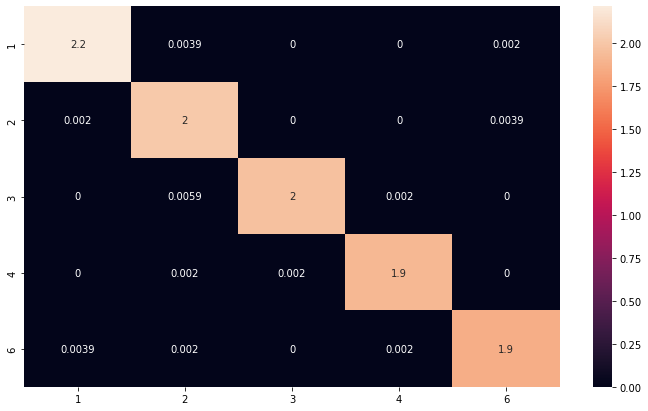

In [ ]:
best_train_net(net)

In [ ]:
net = load_reference_net()
train_test_acc_eval_f(net)

Train err: 0.00%, train loss: 0.00043705475012150905
TEST ERR: 0.33%, test loss: 0.012950082619984945


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Below is for Project 2 Part 1 Part 2 LC Compression

All the code was taken from Yerlan's LC Compression Collab and modified to fit the parameters of the project and our model

We only need to use 3 weight compression types:
AdaptiveQuantization, L0ConstrainedPruning, and RankSelection compressions. 

For each compression type, you will need to vary the amount of compression and report to us 'compression ratio vs error' plots.

## Compression using the LC toolkit

### Step 1: L step
We will use same L step with same hyperparamters for all our compression examples

The compute compression ratio needs to be edited

I can find the total_number_of_parameters using a function that is being called above

428000 is what the function finds

In [ ]:
#based on yerlan's code 
#784x300, 300x100, and 100x10,
# compressed_model_bits = lc_alg.count_param_bits() + (300+100+10)*32
# uncompressed_model_bits = (784*300+300*100+100*10 + 300 + 100 + 10)*32
#i can replace 784*300+300*100+100*10 with total_parameters_no_bias
# so uncompressed_model_bits = (total_parameters_no_bias + 500 + 5)*32
# for compressed_model_bits = lc_alg.count_param_bits() + (500 +5) * 32
def compute_compression_ratio(lc_alg):
    compressed_model_bits = lc_alg.count_param_bits() + (500 +5) * 32
    uncompressed_model_bits = (total_parameters_no_bias)*32
    compression_ratio = uncompressed_model_bits/compressed_model_bits
    return compression_ratio


In [ ]:
def my_l_step(model, lc_penalty, step):
    train_loader, test_loader = data_loader()
    params = list(filter(lambda p: p.requires_grad, model.parameters()))
    # lrate = [0.1, 0.01, 0.001, 0.1*(0.98**step), 0.01*(0.98**step) ]
    lr = 0.001*(0.99**step)
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, nesterov=True)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    print(f'L-step #{step} with lr: {lr:.5f}')
    epochs_per_step_ = 10
    # if step == 0:
    #     epochs_per_step_ = epochs_per_step_ * 2
    for epoch in range(epochs_per_step_):
        avg_loss = []
        for x, target in train_loader:
            x = x.to(device)[:,None,:,:]
            target = target.to(dtype=torch.long, device=device)
            optimizer.zero_grad()
            out = model(x)
            #loss = model.loss(out, target) + lc_penalty()
            loss = nnloss(out,target) + lc_penalty()
            avg_loss.append(loss.item())
            loss.backward()
            optimizer.step()
        #scheduler.step()
        print(f"\tepoch #{epoch} is finished.")
        print(f"\t  avg. train loss: {np.mean(avg_loss):.6f}")

### Step 2: Schedule of mu values

In [ ]:
mu_s = [5e-3 * (1.25 ** n) for n in range(15)] # 10e-5 1.4 ** n
# 5 L-C steps in total
# total training epochs is 3 x 5 = 15

### Compression time! Pruning
Let us prune all but 5% of the weights in the network (5% = 21,400 weights)

I am using the function called above to find total parameters, which gives us 428000

In [ ]:
total_weights = total_parameters_no_bias
prune_offset = [0.13, 0.10, 0.07, 0.04, 0.03, 0.025]
pruning_compression_ratios = []
pruning_train_err = []
pruning_test_err = []
num_parameters_weights = []
pruning_num_parameters = []
for i in prune_offset:
  net = load_reference_net()
  avg_train_err.clear()
  avg_test_err.clear()
  layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
  compression_tasks = {
      Param(layers, device): (AsVector, ConstraintL0Pruning(kappa=int(total_weights*i)), 'pruning')
  }

  lc_alg = lc.Algorithm(
      model=net,                            # model to compress
      compression_tasks=compression_tasks,  # specifications of compression
      l_step_optimization=my_l_step,        # implementation of L-step
      mu_schedule=mu_s,                     # schedule of mu values
      evaluation_func=train_test_acc_eval_f # evaluation function
  )
  lc_alg.run()                              # entry point to the LC algorithm
  pruning_compression_ratios.append(compute_compression_ratio(lc_alg))
  pruning_train_err.append(avg_train_err[-1])
  pruning_test_err.append(avg_test_err[-1])
  num_parameters_weights.append(int(total_weights*i))
  pruning_num_parameters.append(lc_alg.count_params())
  print(f"Inserting compression ratio: {compute_compression_ratio(lc_alg)}")

from retrieve 246.0872446651058
L0 constrained pruning.
l0-cons pruning finished. #zeros: 86.18%
Direct compression has been performed.
Train err: 0.09%, train loss: 0.003234356672813495
TEST ERR: 0.39%, test loss: 0.01540922528753678
0.0001
L-step #0 with lr: 0.05000
	epoch #0 is finished.
	  avg. train loss: 0.006394
	epoch #1 is finished.
	  avg. train loss: 0.006391
	epoch #2 is finished.
	  avg. train loss: 0.006374
	epoch #3 is finished.
	  avg. train loss: 0.006364
	epoch #4 is finished.
	  avg. train loss: 0.006348


KeyboardInterrupt: ignored

In [ ]:
print(f"Pruning Compression Ratios: {pruning_compression_ratios}")
print(f"pruning_train_err: {pruning_train_err}")
print(f"pruning_test_err: {pruning_test_err}")
print(f"num_parameters_weights: {num_parameters_weights}")
print(f"pruning_num_parameters: {pruning_num_parameters}")
# These results were found using 30 L-C steps with 10 epochs per step. 6 Different configurations were ran.
# Pruning Compression Ratios: [6.65839233167264, 8.50902646256494, 11.872071951951224, 19.984842478371384, 26.019822045621446, 30.832342101890347]
# pruning_train_err: [0.0862577123147126, 0.09100294098728103, 0.15448355567365793, 0.35547035233850105, 0.5792342466316784, 0.4917111400042814]
# pruning_test_err: [0.37194172492702743, 0.39022360632174563, 0.42867859822098214, 0.6196927383106263, 0.7577524633259126, 0.7136237840972842]
# num_parameters_weights: [55640, 42800, 29960, 17120, 12840, 10700]
# pruning_num_parameters: [55640, 42800, 29960, 17120, 12840, 10700]

In [ ]:
fig = plt.figure(1)
plt.plot(pruning_compression_ratios,pruning_train_err,color = "blue", label = "L0Constrained-Pruning_train_err", marker = "o")
plt.plot(pruning_compression_ratios,pruning_test_err,color = "red", label = "L0Constrained-Pruning_test_err", marker = "o")
plt.title('Compression Ratio vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Compression Ratio")
plt.ylabel("Error %")
plt.savefig('pruning-compression.png')

In [ ]:
plt.plot(pruning_num_parameters,pruning_train_err,color = "blue", label = "L0Constrained-Pruning_train_err", marker = "o")
plt.plot(pruning_num_parameters,pruning_test_err,color = "red", label = "L0Constrained-Pruning_test_err", marker = "o")
plt.title('Number of Parameters vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Number of Parameters")
plt.ylabel("Error %")
plt.savefig('pruning-parameters.png')

Note that we were pruning 95% of the weights. Naively, you would assume 20x compression ratio (100%/5%), however, this is not the case. Firstly, there are some uncompressed parts (in this case biases), and, secondly, storing a compressed model requires additional metadata (in this case positions of non-zero elements). Therefore we get only 16x compression ratio (vs naively expected 20x). 

To prevent manual computation of compression ratio, let us create a function below. Note, this function is model specific.

### Quantization
Now let us quantize each layer with its own codebook

Looks like k = # of codebooks as on the [github](https://github.com/UCMerced-ML/LC-model-compression/blob/f8a0a3eb1ff18f9796fa15a063925d9d32a1cee1/lc/compression_types/quantization.py)

In [ ]:
k_values = [2,4,15, 30] # K_values is also = to size of codebook
quant_compression_ratios = []
quant_train_err = []
quant_test_err = []
quant_num_parameters = []
for i in k_values:
  net = load_reference_net()
  avg_train_err.clear()
  avg_test_err.clear()
  layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]

  compression_tasks = {
      Param(layers[0], device): (AsVector, AdaptiveQuantization(k=i), 'layer0_quant'),
      Param(layers[1], device): (AsVector, AdaptiveQuantization(k=i), 'layer1_quant')
  }

  lc_alg = lc.Algorithm(
      model=net,                            # model to compress
      compression_tasks=compression_tasks,  # specifications of compression
      l_step_optimization=my_l_step,        # implementation of L-step
      mu_schedule=mu_s,                     # schedule of mu values
      evaluation_func=train_test_acc_eval_f # evaluation function
  )
  lc_alg.run()  
  print('Compressed_params:', lc_alg.count_params())
  print('Compression_ratio:', compute_compression_ratio(lc_alg))

  quant_compression_ratios.append(compute_compression_ratio(lc_alg))
  quant_train_err.append(avg_train_err[-1])
  quant_test_err.append(avg_test_err[-1])
  quant_num_parameters.append(lc_alg.count_params())

In [ ]:
print(quant_compression_ratios)
print(quant_train_err)
print(quant_test_err)
print(quant_num_parameters)

In [ ]:
plt.plot(quant_compression_ratios,quant_train_err,color = "blue", label = "Adaptive-Quantization_train_err", marker = "o")
plt.plot(quant_compression_ratios,quant_test_err,color = "red", label = "Adaptive-Quantization_test_err", marker = "o")
plt.title('Compression Ratio vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Compression Ratio")
plt.ylabel("Error %")  


In [ ]:
plt.plot(quant_num_parameters,quant_train_err,color = "blue", label = "Adaptive-Quantization_train_err" ,marker = "o")
plt.plot(quant_num_parameters,quant_test_err,color = "red", label = "Adaptive-Quantization_test_err",marker = "o")
plt.title('Size of Codebook vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Size of Codebook")
plt.ylabel("Error %")

### Low-rank compression with automatic rank selection

In [ ]:
alpha_values = [6.62e-8, 9.62e-8, 1.92e-7, 2.12e-7] #compression numbere 5 , 12.9, 20, 26
ranksel_compression_ratios = []
ranksel_train_err = []
ranksel_test_err = []
ranksel_num_parameters = []
for i in alpha_values:
  net = load_reference_net()
  print(f"Initial train/test errors")
  train_test_acc_eval_f(net)
  avg_train_err.clear()
  avg_test_err.clear()
  layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
  compression_tasks = {
      Param(layers[0], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=i, criterion='storage', module=layers[0], normalize=True), "layer1_lr"),
      Param(layers[1], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=i, criterion='storage', module=layers[1], normalize=True), "layer2_lr")
  }

  lc_alg = lc.Algorithm(
      model=net,                            # model to compress
      compression_tasks=compression_tasks,  # specifications of compression
      l_step_optimization=my_l_step,        # implementation of L-step
      mu_schedule=mu_s,                     # schedule of mu values
      evaluation_func=train_test_acc_eval_f # evaluation function
  )
  lc_alg.run()
  print('Compressed_params:', lc_alg.count_params())
  print('Compression_ratio:', compute_compression_ratio(lc_alg))

  ranksel_compression_ratios.append(compute_compression_ratio(lc_alg))
  # ranksel_train_err.append(avg_train_err)
  # ranksel_test_err.append(avg_test_err)
  ranksel_train_err.append(avg_train_err[-1])
  ranksel_test_err.append(avg_test_err[-1])
  ranksel_num_parameters.append(lc_alg.count_params())

Initial train/test errors
Train err: 0.00%, train loss: 0.00043602517204514396
TEST ERR: 0.33%, test loss: 0.012941837310791016
from retrieve 216.08541488785428
from retrieve 29.998205942895535
for this layer, selected rank is 0, normalized ‖w‖²=1.000, true ‖w‖²=216.085, ‖Δ(Θ)‖²=0.000, ‖w-Δ(Θ)‖²=1.000e+00, μ should be at least 6.78e-03
for this layer, selected rank is 0, normalized ‖w‖²=1.000, true ‖w‖²=29.998, ‖Δ(Θ)‖²=0.000, ‖w-Δ(Θ)‖²=1.000e+00, μ should be at least 6.37e-04
Direct compression has been performed.
Train err: 80.65%, train loss: 1.620549464225769
TEST ERR: 81.28%, test loss: 1.5911225875218709
0.005
L-step #0 with lr: 0.00100
	epoch #0 is finished.
	  avg. train loss: 0.615452
	epoch #1 is finished.
	  avg. train loss: 0.614742
	epoch #2 is finished.
	  avg. train loss: 0.613866
	epoch #3 is finished.
	  avg. train loss: 0.612958
	epoch #4 is finished.
	  avg. train loss: 0.612046
	epoch #5 is finished.
	  avg. train loss: 0.611134
	epoch #6 is finished.
	  avg. train l

In [ ]:
print(ranksel_compression_ratios)
print(ranksel_train_err)
print(ranksel_test_err)
print(ranksel_num_parameters)
# alpha_values = [6.62e-8, 9.62e-8, 1.92e-7, 2.12e-7] #compression numbere 5 , 12.9, 20, 26

# 5x compression
# alpha = 6.62e-8
# Train err: 0.00%, train loss: 0.0006606075059001644
# TEST ERR: 0.33%, test loss: 0.01402194673816363

# 12x compression
# alpha = 1.72e-7
# Train err: 3.80%, train loss: 0.12177502165238062
# TEST ERR: 3.77%, test loss: 0.1069244456787904
# Compressed_params: 33725
# Compression_ratio: 12.503651767455448

# 20x
# alpha = 1.92e-7
# Train err: 2.86%, train loss: 0.09001585940519968
# TEST ERR: 2.48%, test loss: 0.07083041220903397
# Compressed_params: 20725
# Compression_ratio: 20.160150730098916

# 26x compression
# alpha = 2.12e-7
# Train err: 4.59%, train loss: 0.1115847259759903
# TEST ERR: 5.02%, test loss: 0.11344242530564468
# Compressed_params: 15525
# Compression_ratio: 26.699937616968185
# [26.699937616968185]
# [57.41006341734497]
# [57.070793433652526]

[]
[]
[]
[]


In [ ]:
print(sum(ranksel_train_err[0])/len(ranksel_train_err[0]))

23.43025199273242


In [ ]:
plt.plot(ranksel_compression_ratios,ranksel_train_err,color = "blue", label = "Rank-Selection-compression_train_err", marker = "o")
plt.plot(ranksel_compression_ratios,ranksel_test_err,color = "red", label = "Rank-Selection-compression_test_err", marker = "o")
plt.title('Compression Ratio vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Compression Ratio")
plt.ylabel("Error %")

In [ ]:
plt.plot(quant_compression_ratios,quant_test_err,color = "blue", label = "Adaptive-Quantization_test_err", marker = 'o')
plt.plot(pruning_compression_ratios,pruning_test_err,color = "red", label = "L0Constrained-Pruning_test_err", marker = 'o')
plt.plot(ranksel_compression_ratios,ranksel_test_err,color = "green", label = "Rank-Selection-compression_test_err", marker = 'o')
plt.title('Compression Ratio vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Compression Ratio")
plt.ylabel("Error %")

In [ ]:
plt.plot(quant_num_parameters,quant_test_err,color = "blue", label = "Adaptive-Quantization_test_err",marker = "o")
plt.plot(pruning_num_parameters,pruning_test_err,color = "red", label = "L0Constrained-Pruning_test_err", marker = "o")
plt.plot(ranksel_num_parameters,ranksel_test_err,color = "green", label = "Rank-Selection-compression_test_err",marker = "o")
plt.title('Number of Parameters / Size of Codebook vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Number of Parameters / Size of Codebook")
plt.ylabel("Error %")
plt.show()

## Extra Code Down Below

If you want to use them need to edit it for 2 layers for the fully connected. 

For conv2d im not sure they are "layers"

In [ ]:
total_weights = total_parameters_no_bias
prune_offset = [0.13, 0.10, 0.07, 0.04, 0.03, 0.025]
k_values = [30,15,4,2] 
alpha_values = [6.62e-8, 1.12e-7, 1.92e-7, 2.12e-7] #compression numbere 7 , 11, 15, 21
mix_compression_ratios = []
mix_train_err = []
mix_test_err = []
mix_num_parameters = []
for i in range(len(k_values)):
  net = load_reference_net()
  print(f"Initial train/test errors")
  train_test_acc_eval_f(net)
  avg_train_err.clear()
  avg_test_err.clear()
  layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
  compression_tasks = {
      Param(layers[0], device): (AsVector, AdaptiveQuantization(k=k_values[i]), 'layer0_quant'),
      Param(layers[1], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=alpha_values[i], criterion='storage', module=layers[1], normalize=True), "layer2_lr")
  }

  lc_alg = lc.Algorithm(
      model=net,                            # model to compress
      compression_tasks=compression_tasks,  # specifications of compression
      l_step_optimization=my_l_step,        # implementation of L-step
      mu_schedule=mu_s,                     # schedule of mu values
      evaluation_func=train_test_acc_eval_f # evaluation function
  )
  lc_alg.run()
  print('Compressed_params:', lc_alg.count_params())
  print('Compression_ratio:', compute_compression_ratio(lc_alg))
  mix_compression_ratios.append(compute_compression_ratio(lc_alg))
  mix_train_err.append(avg_train_err[-1])
  mix_test_err.append(avg_test_err[-1])
  mix_num_parameters.append(lc_alg.count_params())

In [ ]:
print(mix_compression_ratios)
print(mix_train_err)
print(mix_test_err)
print(mix_num_parameters)

In [ ]:
plt.plot(mix_compression_ratios,mix_train_err,color = "blue", label = "Mixture-Of-compression_train_err", marker = "o")
plt.plot(mix_compression_ratios,mix_test_err,color = "red", label = "Mixture-Of-compression_test_err", marker = "o")
plt.title('Compression Ratio vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Compression Ratio")
plt.ylabel("Error %")

In [ ]:
plt.plot(mix_num_parameters,mix_train_err,color = "blue", label = "Mixture-Of-compression_train_err",marker = "o")
plt.plot(mix_num_parameters,mix_test_err,color = "red", label = "Mixture-Of-compression_test_err", marker = "o")
plt.title('Number of Parameters vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Number of Parameters")
plt.ylabel("Error %")

In [ ]:
total_weights = total_parameters_no_bias
prune_offset = [0.13, 0.10, 0.07, 0.04, 0.03, 0.025]
k_values = [30,15,4,2] 
#alpha_values = [6.62e-8, 1.12e-7, 1.92e-7, 2.12e-7] #compression numbere 7 , 11, 15, 21
mix2_compression_ratios = []
mix2_train_err = []
mix2_test_err = []
mix2_num_parameters = []
for i in range(len(k_values)):
  net = load_reference_net()
  print(f"Initial train/test errors")
  train_test_acc_eval_f(net)
  avg_train_err.clear()
  avg_test_err.clear()
  layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
  compression_tasks = {
      Param(layers[0], device): (AsVector, ConstraintL0Pruning(kappa=int(total_weights*i)), 'pruning'),
      Param(layers[1], device): (AsIs, RankSelection(conv_scheme='scheme_1', alpha=i, criterion='storage', module=layers[1], normalize=True), "layer2_lr")
  }

  lc_alg = lc.Algorithm(
      model=net,                            # model to compress
      compression_tasks=compression_tasks,  # specifications of compression
      l_step_optimization=my_l_step,        # implementation of L-step
      mu_schedule=mu_s,                     # schedule of mu values
      evaluation_func=train_test_acc_eval_f # evaluation function
  )
  lc_alg.run()
  print('Compressed_params:', lc_alg.count_params())
  print('Compression_ratio:', compute_compression_ratio(lc_alg))
  mix2_compression_ratios.append(compute_compression_ratio(lc_alg))
  mix2_train_err.append(avg_train_err[-1])
  mix2_test_err.append(avg_test_err[-1])
  mix2_num_parameters.append(lc_alg.count_params())

In [ ]:
print(mix2_compression_ratios)
print(mix2_train_err)
print(mix2_test_err)
print(mix2_num_parameters)

In [ ]:
plt.plot(mix2_compression_ratios,mix2_train_err,color = "blue", label = "Mixture-Of-compression_train_err", marker = "o")
plt.plot(mix2_compression_ratios,mix2_test_err,color = "red", label = "Mixture-Of-compression_test_err", marker = "o")
plt.title('Compression Ratio vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Compression Ratio")
plt.ylabel("Error %")

In [ ]:
plt.plot(mix2_num_parameters,mix2_train_err,color = "blue", label = "Mixture-Of-compression_train_err",marker = "o")
plt.plot(mix2_num_parameters,mix2_test_err,color = "red", label = "Mixture-Of-compression_test_err", marker = "o")
plt.title('Number of Parameters vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Number of Parameters")
plt.ylabel("Error %")

In [ ]:
total_weights = total_parameters_no_bias
prune_offset = [0.13, 0.10, 0.07, 0.04, 0.03, 0.025]
k_values = [30,15,4,2] 
#alpha_values = [6.62e-8, 1.12e-7, 1.92e-7, 2.12e-7] #compression numbere 7 , 11, 15, 21
mix3_compression_ratios = []
mix3_train_err = []
mix3_test_err = []
mix3_num_parameters = []
for i in range(len(k_values)):
  net = load_reference_net()
  print(f"Initial train/test errors")
  train_test_acc_eval_f(net)
  avg_train_err.clear()
  avg_test_err.clear()
  layers = [lambda x=x: getattr(x, 'weight') for x in net.modules() if isinstance(x, nn.Linear)]
  compression_tasks = {
      Param(layers, device): [
          (AsVector, ConstraintL0Pruning(kappa=int(total_weights*prune_offset[i])), 'pruning'),
          (AsVector, AdaptiveQuantization(k=k_values[i]), 'quant')
      ]
  }

  lc_alg = lc.Algorithm(
      model=net,                            # model to compress
      compression_tasks=compression_tasks,  # specifications of compression
      l_step_optimization=my_l_step,        # implementation of L-step
      mu_schedule=mu_s,                     # schedule of mu values
      evaluation_func=train_test_acc_eval_f # evaluation function
  )
  lc_alg.run()
  print('Compressed_params:', lc_alg.count_params())
  print('Compression_ratio:', compute_compression_ratio(lc_alg))
  mix3_compression_ratios.append(compute_compression_ratio(lc_alg))
  mix3_train_err.append(avg_train_err[-1])
  mix3_test_err.append(avg_test_err[-1])
  mix3_num_parameters.append(lc_alg.count_params())

In [ ]:
print(mix3_compression_ratios)
print(mix3_train_err)
print(mix3_test_err)
print(mix3_num_parameters)

In [ ]:
plt.plot(mix3_compression_ratios,mix3_train_err,color = "blue", label = "Mixture-Of-compression_train_err", marker = "o")
plt.plot(mix3_compression_ratios,mix3_test_err,color = "red", label = "Mixture-Of-compression_test_err", marker = "o")
plt.title('Compression Ratio vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Compression Ratio")
plt.ylabel("Error %")

In [ ]:
plt.plot(mix3_num_parameters,mix3_train_err,color = "blue", label = "Mixture-Of-compression_train_err",marker = "o")
plt.plot(mix3_num_parameters,mix3_test_err,color = "red", label = "Mixture-Of-compression_test_err", marker = "o")
plt.title('Number of Parameters vs Train and Test Error')
plt.legend(loc="best")
plt.xlabel("Number of Parameters")
plt.ylabel("Error %")